In [3]:
import sys

sys.path.append('/Users/robertwelch/Desktop/BIIF/Chiara3/Federico-Pietrocola2022-3/src')

from senolysis_analysis import *
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import regionprops, label

In [2]:
def plot_multi(img_list):

    if isinstance(img_list,list):
        n = len(img_list)

        fig,ax = plt.subplots(1,n)
        fig.set_size_inches(15,15)

        for i,img in enumerate(img_list):
            ax[i].imshow(img,cmap='gray')
    else:
        raise Exception('Input is not a list of images')


In [3]:
def find_features(mask,red_raw,green_raw,red_adjusted,green_adjusted):

    nuclei_scenenst = regionprops(label(mask),intensity_image=red_raw)
    nuclei_quiescent = regionprops(label(mask),intensity_image=green_raw)

    nuclei_scenenst_adjusted = regionprops(label(mask),intensity_image=red_adjusted)
    nuclei_quiescent_adjusted = regionprops(label(mask),intensity_image=green_adjusted)
    nuclei = regionprops(label(mask))

    red_intensities_raw = []
    green_intensities_raw = []
    red_intensities_adjusted = []
    green_intensities_adjusted= []
    nuclei_sizes = []


    for i in range(len(nuclei_quiescent)):
        red_intensities_raw.append(nuclei_scenenst[i].mean_intensity)
        green_intensities_raw.append(nuclei_quiescent[i].mean_intensity)
        red_intensities_adjusted.append(nuclei_scenenst_adjusted[i].mean_intensity)
        green_intensities_adjusted.append(nuclei_quiescent_adjusted[i].mean_intensity)
        nuclei_sizes.append(nuclei[i].area)


    X = np.zeros([len(red_intensities_raw),5])
    X[:,0] = red_intensities_raw
    X[:,1] = green_intensities_raw
    X[:,2] = nuclei_sizes
    X[:,3] = red_intensities_adjusted
    X[:,4] = green_intensities_adjusted
   
    
    #Normalize for each image
    #X = X/X.max(axis=0)

    return X

def remove_well_rings(img,max_size = 150):
        from skimage.filters import threshold_mean
        from skimage.morphology import binary_dilation,disk
        from skimage.segmentation import flood_fill


        thresh = threshold_mean(img)
        binary = img > thresh
        regions = regionprops(label(binary))
        # Generate mask of regions below max_size
        removal_mask = np.zeros(img.shape, dtype="bool")
        for region in regions:
            if max_size < region.area:
                removal_mask[tuple(region.coords.T.tolist())] = 1

        #Dilate slightly to ensure well-edge is completely removed
        removal_mask = binary_dilation(removal_mask,disk(15))

        #fill corners of image (Outside of well)
        removal_mask = flood_fill(removal_mask, (0, 0), 1)
        removal_mask = flood_fill(removal_mask, (-1, 0), 1)
        removal_mask = flood_fill(removal_mask, (0, -1), 1)
        removal_mask = flood_fill(removal_mask, (-1, -1), 1)

        #invert mask
        removal_mask = np.abs(removal_mask-1)

        out = removal_mask * img
        return out, removal_mask

In [4]:
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB10_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0048.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB08_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0036.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB10_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0048.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB11_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0054.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/All Images/WellB03_Channel Kinetix Single band tdTomato, Kinetix Single band senolysis  EGFP1, Kinetix Single  Hoechst_Seq0001.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/NewCellLine/WellB04_ChannelSenolysis-MEF,Senolysis EGFP-MEF,Senolysis Hoechst_Seq0012.nd2'
#def main(img_path):
    
red, green, blue = nd2_import(img_path)

downscale_factor = 4
blue_downscaled = downscale_local_mean(
    blue, factors=(downscale_factor, downscale_factor)
)
green_downscaled = downscale_local_mean(
    green, factors=(downscale_factor, downscale_factor)
)
red_downscaled = downscale_local_mean(
    red, factors=(downscale_factor, downscale_factor)
)

# normalize to [0,1] for 0 to 99th percentiles
red_norm, green_norm, blue_norm = (
    normalize_img(red_downscaled, high_per=98),
    normalize_img(green_downscaled, high_per=98),
    normalize_img(blue_downscaled, high_per=98),
)

# downscale the images for faster computation @300ms each


# Smooth the blue channel for nuclei segmentation
blue_smoothed = gaussian(blue_norm, 1)  # smooth image

# remove the well ring from the blue channel
blue_no_well_ring, removal_mask = remove_well_rings(blue_smoothed,max_size=10000)

nuclei_thresholded = threshold_with_otsu(blue_no_well_ring)
nuclei_thresholded_upscaled = remove_small_objects(nuclei_thresholded,min_size=50)
nuclei_thresholded_upscaled = remove_large_nuclei(nuclei_thresholded,1000)
nuclei_thresholded_upscaled = resize(nuclei_thresholded, output_shape=blue.shape)



# Determine if each nuclei belongs to scenescent or quiescent cell #500ms

X = find_features(nuclei_thresholded,red_downscaled,green_downscaled,red_norm,green_norm)



In [5]:
from sklearn.mixture import GaussianMixture

X_for_clustering = X[:,:3]

GM = GaussianMixture(n_components=2, random_state=0,covariance_type = 'diag').fit(X_for_clustering)

labels = GM.predict(X_for_clustering)


X_color_01 = np.zeros([len(X),3])
X_color_01[:,:-1] = X[:,3:]/X[:,3:].max(axis=0) # have to normalize colours
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Mean Nuclei Intensities')
plt.scatter(X[:,0],X[:,1],c = X_color_01)
plt.ylabel('Green Channel Intensities')
plt.xlabel('Red Channel Intensities')
plt.axvline(4000, color='black',ls = '--',c = 'r',label = 'Scenescent Threshold')
plt.legend()
plt.minorticks_on()
plt.yscale('log')
plt.xscale('log')


plt.subplot(1,2,2)
plt.title('Gaussian Mixture Model Classification')
plt.scatter(X[:,0],X[:,1],c = labels)
plt.ylabel('Green Channel Intensities')
plt.xlabel('Red Channel Intensities')
plt.minorticks_on()
plt.yscale('log')
plt.xscale('log')


ModuleNotFoundError: No module named 'sklearn'

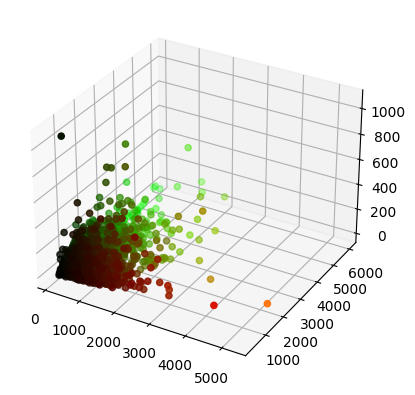

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2],c=X_color_01)

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 2s 2s/step


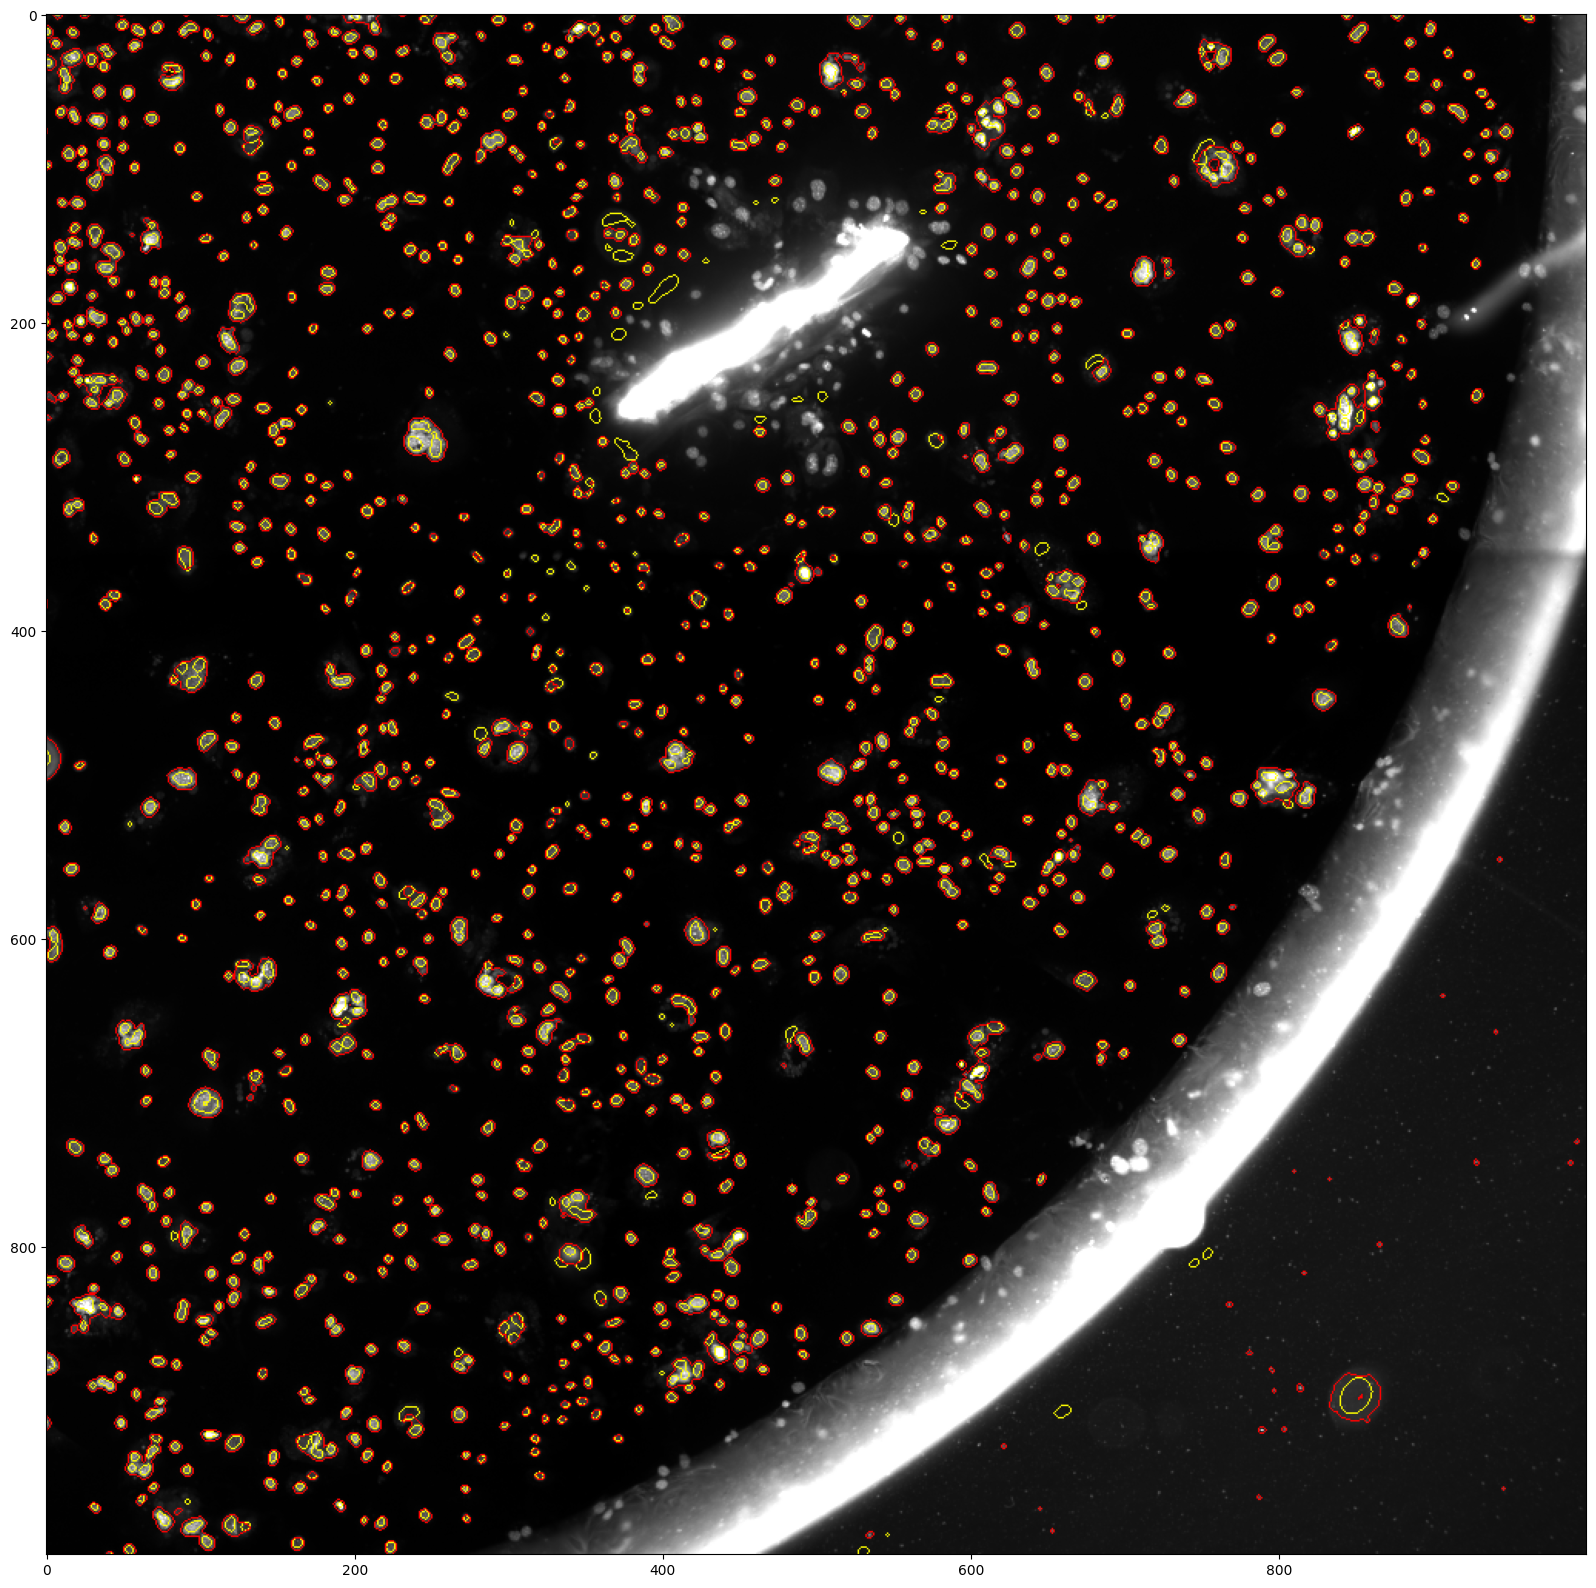

In [49]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from skimage.transform import downscale_local_mean
from skimage.segmentation import mark_boundaries

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/NewCellLine/WellB04_ChannelSenolysis-MEF,Senolysis EGFP-MEF,Senolysis Hoechst_Seq0012.nd2'
#def main(img_path):
    
red, green, blue = nd2_import(img_path)

downscale_factor = 4
blue_downscaled = downscale_local_mean(
    blue, factors=(downscale_factor, downscale_factor)
)
green_downscaled = downscale_local_mean(
    green, factors=(downscale_factor, downscale_factor)
)
red_downscaled = downscale_local_mean(
    red, factors=(downscale_factor, downscale_factor)
)

# normalize to [0,1] for 0 to 99th percentiles
red_norm, green_norm, blue_norm = (
    normalize_img(red_downscaled, high_per=98),
    normalize_img(green_downscaled, high_per=98),
    normalize_img(blue_downscaled, high_per=98),
)

# downscale the images for faster computation @300ms each


# Smooth the blue channel for nuclei segmentation
blue_smoothed = gaussian(blue_norm, 1)  # smooth image

# remove the well ring from the blue channel
blue_no_well_ring = remove_well_rings(blue_smoothed)

nuclei_thresholded = threshold_with_otsu(blue_no_well_ring)
labels, _ = model.predict(normalize(blue_no_well_ring))

labels_reshape = resize(labels, blue_downscaled.shape,
                       anti_aliasing=True)


overlay = mark_boundaries(blue_norm,labels_reshape>0.5)
overlay = mark_boundaries(overlay,nuclei_thresholded,color=(1,0,0))

plt.figure(figsize=(20,20))
plt.imshow(overlay[1000:2000,1000:2000])
